# MODNet 'matbench_expt_is_metal' benchmarking

Matbench v0.1 test dataset for classifying metallicity from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, ensuring no conflicting reports were entered for any compositions (i.e., no reported compositions were both metal and nonmetal). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	is_metal: Target variable. 1 if is a metal, 0 if nonmetal.
Num Entries: 4921
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673 
 https//:doi.org/10.1021/acs.jpclett.8b00124.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
#from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [2]:
import modnet
modnet.__version__

'0.1.8'

In [3]:
Markdown(filename="./README.md")

# matbench_expt_is_metal

## Introduction

- Classification task (1: metal, 0: non-metal)
- 4921 experimental compounds with composition only

Results to beat:

| Method | ROC_AUC |
|:-------|-----------------:|
| AM     | 0.92 |
| RF     | -  |
| Dummy  | -  |

## Notes



## To-do



## Results

| Method | Yield strength (MPa) |
|:-------|---------------------:|
| Rough MODNet baseline   | - |


## Data exploration

In [4]:
df = load_dataset("matbench_expt_is_metal")
df["composition"] = df["composition"].map(Composition)

In [5]:
df.columns

Index(['composition', 'is_metal'], dtype='object')

In [6]:
df.head()

,composition,is_metal
0,"(Ag, Au, S)",True
1,"(Ag, W, Br)",True
2,"(Ag, Ge, Pb, S)",False
3,"(Ag, Ge, Pb, Se)",False
4,"(Ag, B, Br)",True


### Composition space

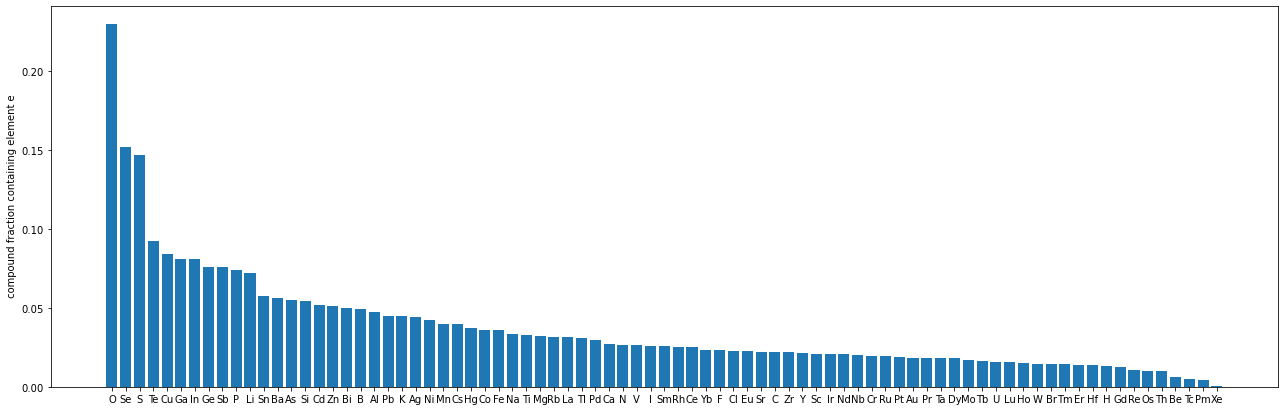

In [7]:
## /!\ the interpretation is different from the steels
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    tot = np.sum(list(s.values()))
    for e in s:
        elements[e] += 1
        proportions[e] += [s[e]/tot]
        
for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w",figsize=(22,7));
#ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel(" compound fraction containing element e");

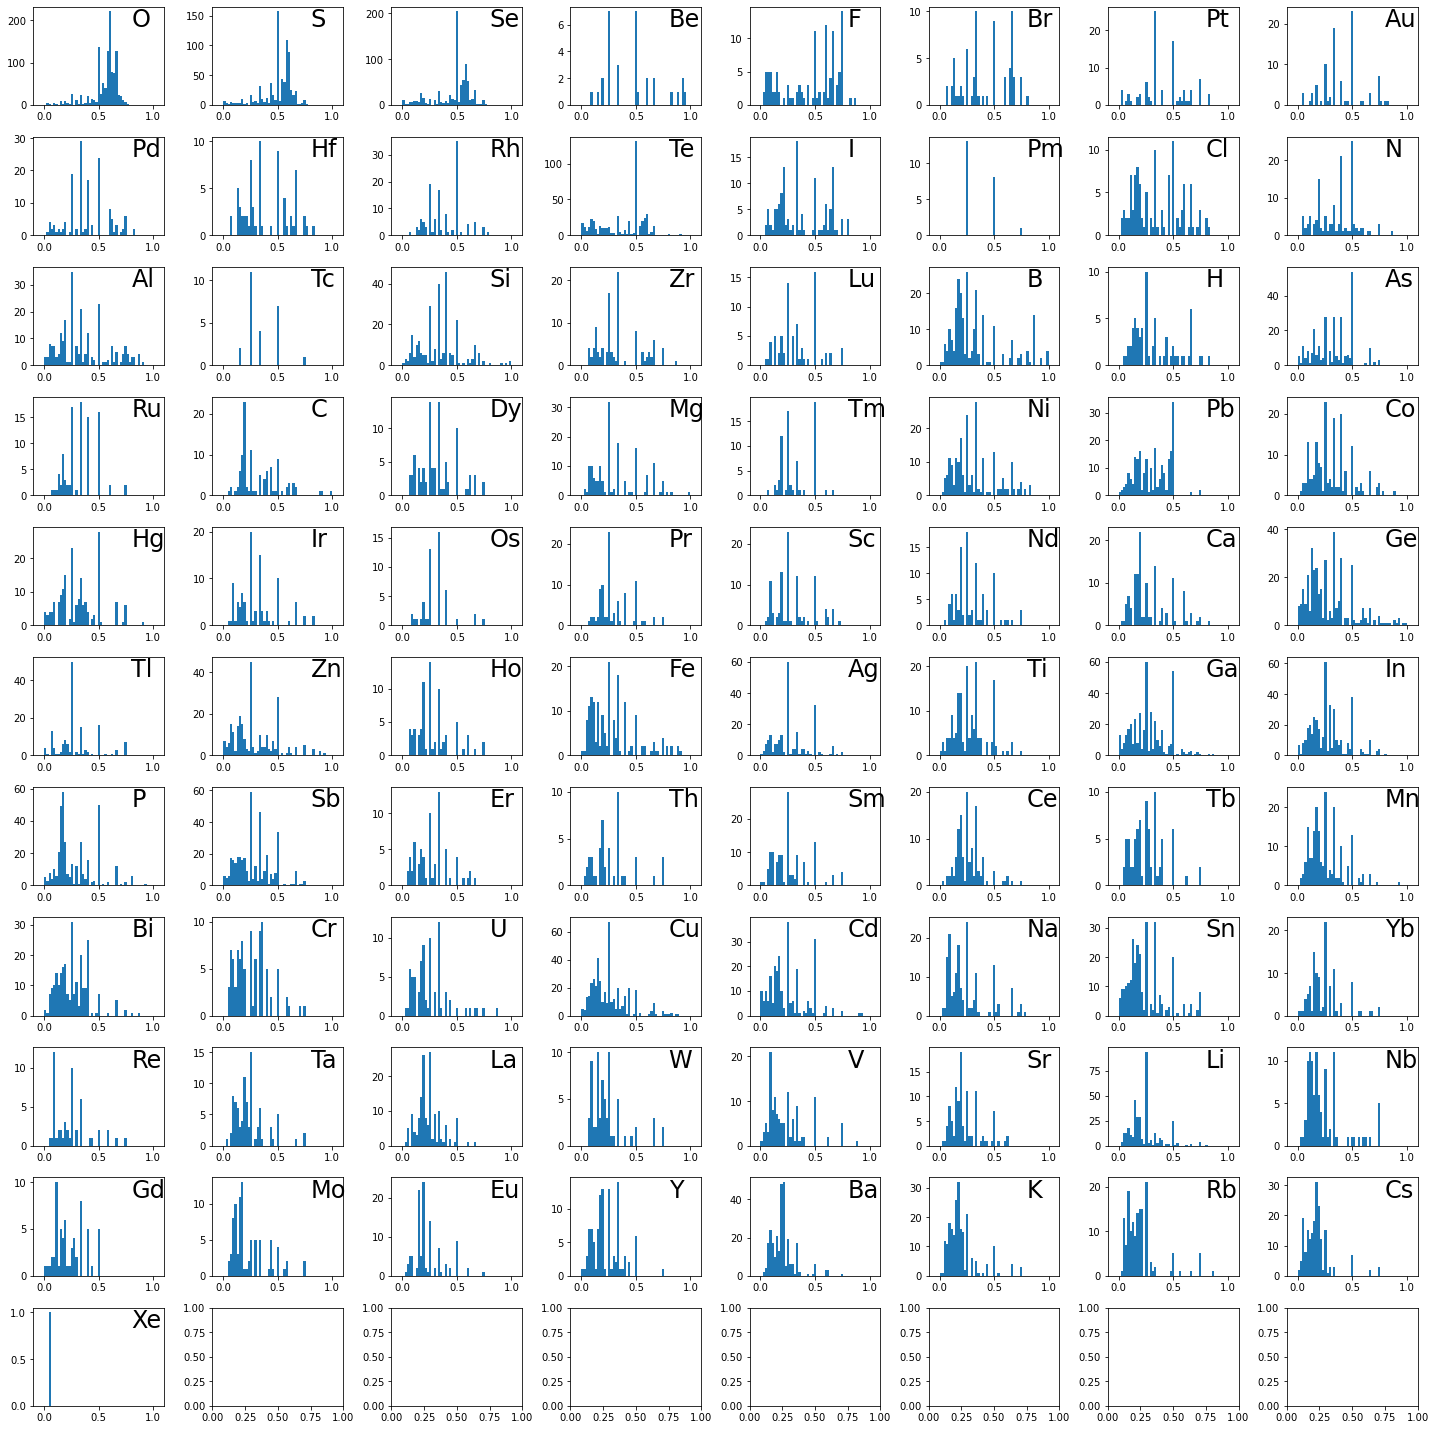

In [8]:
# distribution of element proportions across compositions
fig, axis = plt.subplots(11, 8, facecolor="w", figsize=(20, 20))
for ax, elem in zip(axis.flatten(), mean_proportions):
    ax.hist(
        proportions[elem], 
        bins=np.linspace(0, 1, 50), 
        density=False, 
    )
    ax.set_xlim(-0.1, 1.1)
    ax.text(0.75, 0.8, elem, fontsize=24, transform=ax.transAxes, )
    #ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [9]:
df['is_metal'] = df['is_metal'].map(int)
df.describe()

,is_metal
count,4921.000000
mean,0.498069
std,0.500047
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Text(0.5, 0, 'is metal')

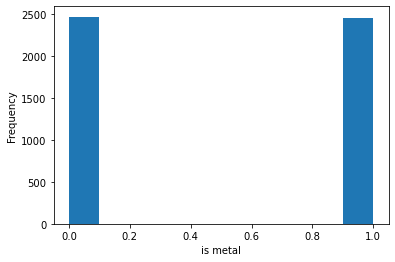

In [10]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["is_metal"]);
ax.set_ylabel("Frequency")
ax.set_xlabel("is metal")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [11]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [12]:
PRECOMPUTED_MODDATA = "./precomputed/expt_is_metal_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_expt_is_metal")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["is_metal"].tolist(), 
        target_names=["is_metal"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8),
        num_classes = {'is_metal':2}
    )
    data.featurize()
    # As this is a small data/feature set, order all features 
    data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7fec8b2a8d60> object, created with modnet version 0.1.8


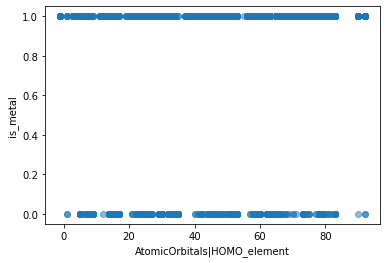

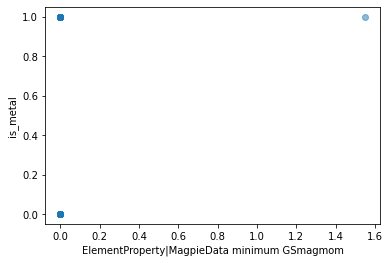

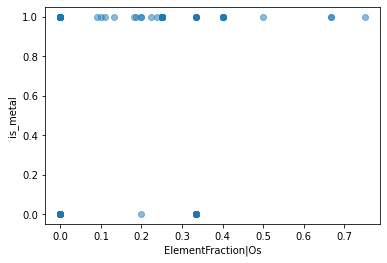

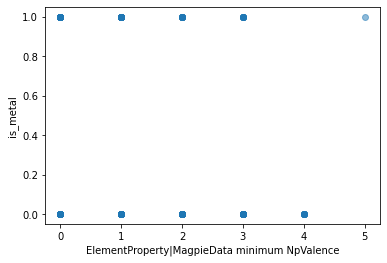

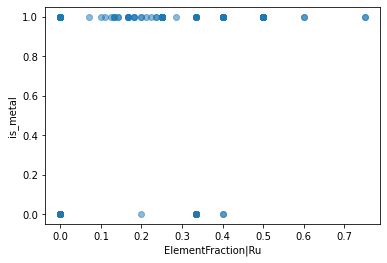

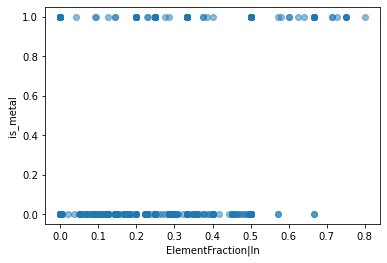

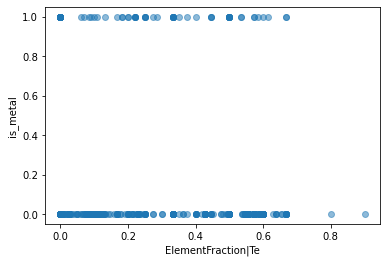

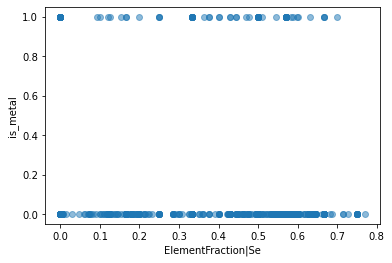

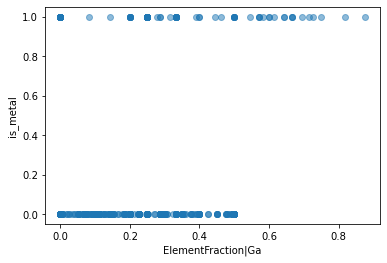

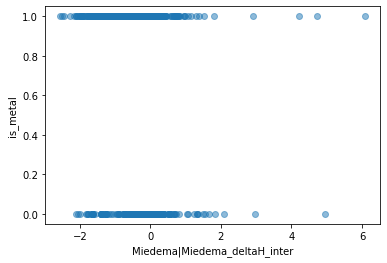

In [13]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("is_metal")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [14]:
try:
    plot_benchmark
except:
    import sys
    sys.path.append('..')
    from modnet_matbench.utils import *

In [16]:
from sklearn.model_selection import KFold
#from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data.df_targets['is_metal'] = data.df_targets['is_metal'].map(int)

best_settings = {
    "increase_bs":False,
    "num_neurons": [[128], [32], [32], [16]],
    "n_feat": 120,
    "lr": 0.005, #0.005
    "epochs": 100,
    "verbose": 0,
    "act": "elu",
    "batch_size": 64,
    "num_classes": {'is_metal':2},
    "loss": "categorical_crossentropy",
    #"xscale": "standard",
}

results = matbench_benchmark(data, [[["is_metal"]]], {"is_metal": 1}, best_settings,classification=True, save_folds=True)
np.mean(results['scores'])

INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: ROC_AUC = 0.9543400644804869


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: ROC_AUC = 0.9655895248839794


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: ROC_AUC = 0.9450579185669906


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: ROC_AUC = 0.9538844679128035


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #5: ROC_AUC = 0.9621405063919162


0.9562024964472353

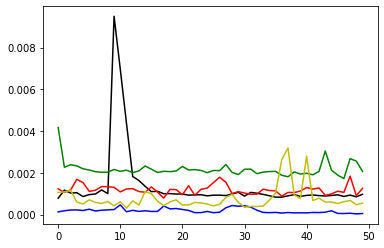

In [16]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    #plt.plot(results["models"][i].history.history["val_loss"][50:],':',c=c)

## Feature selection

In [17]:
model = results['models'][0]

In [18]:
def process(data):
    x = data.get_featurized_df()[model.optimal_descriptors[:model.n_feat]]
    x = model._scaler.transform(x)
    x = np.nan_to_num(x)
    return x

In [19]:
try:
    matbench_kfold_splits()
except:
    os.chdir("..")
    from modnet_matbench.utils import matbench_kfold_splits


In [20]:
import shap
shap.initjs()
for train, test in matbench_kfold_splits(data):
    train_moddata, test_moddata = data.split((train, test))
    break

X_train = shap.sample(process(train_moddata))
explainer = shap.KernelExplainer(model.model.predict, X_train)

In [ ]:
shap_values = explainer.shap_values(X_train, nsamples=1000)

INFO:shap:num_full_subsets = 0
INFO:shap:remaining_weight_vector = [0.18814048 0.09488119 0.06380416 0.04827289 0.03896006 0.0327566
 0.02833003 0.02501413 0.02243877 0.02038189 0.01870215 0.01730537
 0.01612633 0.01511843 0.01424753 0.01348801 0.01282029 0.01222913
 0.01170252 0.01123083 0.0108063  0.01042255 0.01007434 0.00975729
 0.00946771 0.00920252 0.00895907 0.00873509 0.00852865 0.00833804
 0.00816182 0.0079987  0.00784757 0.00770744 0.00757743 0.00745679
 0.00734482 0.00724093 0.00714458 0.00705527 0.00697258 0.00689613
 0.00682556 0.00676058 0.00670089 0.00664627 0.00659647 0.00655132
 0.00651063 0.00647425 0.00644204 0.00641388 0.00638968 0.00636934
 0.0063528  0.00633999 0.00633087 0.00632541 0.0063236 ]
INFO:shap:num_paired_subset_sizes = 58
INFO:shap:weight_left = 1.0
INFO:shap:np.sum(w_aug) = 118.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = [ 0.05395756  0.          0.          0.0072937   0.          0.
  0.          0.          0.        


Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-0e701ef90de8>", line 1, in <module>
    shap_values = explainer.shap_values(X_train, nsamples=1000)
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 178, in shap_values
    explanations.append(self.explain(data, **kwargs))
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 368, in explain
    self.run()
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 514, in run
    eyVal += self.y[i * self.N + j, :] * self.data.weights[j]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ppd

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-0e701ef90de8>", line 1, in <module>
    shap_values = explainer.shap_values(X_train, nsamples=1000)
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 178, in shap_values
    explanations.append(self.explain(data, **kwargs))
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 368, in explain
    self.run()
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 514, in run
    eyVal += self.y[i * self.N + j, :] * self.data.weights[j]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ppde

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-0e701ef90de8>", line 1, in <module>
    shap_values = explainer.shap_values(X_train, nsamples=1000)
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 178, in shap_values
    explanations.append(self.explain(data, **kwargs))
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 368, in explain
    self.run()
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/shap/explainers/_kernel.py", line 514, in run
    eyVal += self.y[i * self.N + j, :] * self.data.weights[j]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ppde

In [20]:
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[0], 
    feature_names=model.optimal_descriptors[:model.n_feat], 
    out_names=["is_not_metal"],
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



ERROR! Session/line number was not unique in database. History logging moved to new session 1292
Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-04549bf56acf>", line 3, in <module>
    shap_values[0],
NameError: name 'shap_values' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/ultra

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-04549bf56acf>", line 3, in <module>
    shap_values[0],
NameError: name 'shap_values' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=as

TypeError: object of type 'NoneType' has no len()

In [ ]:
shap.summary_plot(shap_values[0], X_train, max_display=32, plot_type="dot", feature_names=model.optimal_descriptors[:model.n_feat])